Размер датасета: (2111, 15)

Первые 5 строк:
   Gender   Age family_history_with_overweight FAVC  FCVC  NCP       CAEC  \
0  Female  21.0                            yes   no   2.0  3.0  Sometimes   
1  Female  21.0                            yes   no   3.0  3.0  Sometimes   
2    Male  23.0                            yes   no   2.0  3.0  Sometimes   
3    Male  27.0                             no   no   3.0  3.0  Sometimes   
4    Male  22.0                             no   no   2.0  1.0  Sometimes   

  SMOKE  CH2O  SCC  FAF  TUE        CALC                 MTRANS  \
0    no   2.0   no  0.0  1.0          no  Public_Transportation   
1   yes   3.0  yes  3.0  0.0   Sometimes  Public_Transportation   
2    no   2.0   no  2.0  1.0  Frequently  Public_Transportation   
3    no   2.0   no  2.0  0.0  Frequently                Walking   
4    no   2.0   no  0.0  0.0   Sometimes  Public_Transportation   

            NObeyesdad  
0        Normal_Weight  
1        Normal_Weight  
2        Norma

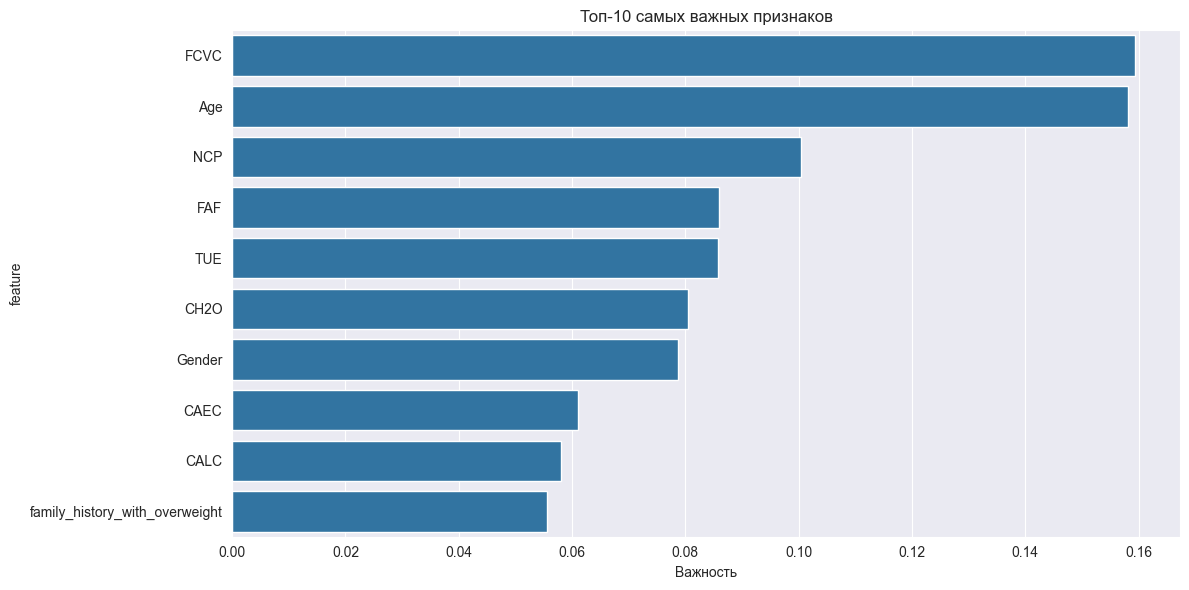


МОДЕЛЬ ГОТОВА К ИСПОЛЬЗОВАНИЮ!
Используйте функцию predict_obesity_category() для предсказаний.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import warnings

warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('ObesityDataSet_no_height_weight.csv')

# Проверка данных
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nПропущенные значения:")
print(df.isnull().sum())

# Преобразование целевой переменной в числовой формат
obesity_levels = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6}

# Кодирование категориальных переменных
label_encoders = {}
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
                    'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"\nКодирование для {col}:")
    print(dict(zip(le.classes_, le.transform(le.classes_))))

# Разделение на признаки и целевую переменную
X = df.drop('NObeyesdad', axis=1)  # Признаки
y = df['NObeyesdad']  # Целевая переменная

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Масштабирование числовых признаков
scaler = StandardScaler()
numeric_cols = ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Обучение модели Random Forest
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

model.fit(X_train, y_train)

# param_grid = {
#     'max_depth': [3, 5, 7, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'criterion': ['gini', 'entropy']
# }
# grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
# grid_search.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)
# y_pred = grid_search.predict(X_test)

# Оценка модели
print("\n" + "=" * 50)
print("ОЦЕНКА МОДЕЛИ")
print("=" * 50)
print(f"Точность модели: {accuracy_score(y_test, y_pred):.4f}")
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred,
                            target_names=label_encoders['NObeyesdad'].classes_))

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "=" * 50)
print("ВАЖНОСТЬ ПРИЗНАКОВ")
print("=" * 50)
print(feature_importance)


# Функция для предсказания на новых данных
def predict_obesity_category(new_data):
    """
    Предсказывает категорию ожирения для новых данных

    Параметры:
    new_data (dict): Словарь с признаками
    """

    # Создаем DataFrame из входных данных
    input_df = pd.DataFrame([new_data])

    # Кодируем категориальные переменные
    for col in categorical_cols:
        if col != 'NObeyesdad':  # Целевую переменную не кодируем
            if col in input_df.columns:
                # Используем сохраненные LabelEncoders
                if col in label_encoders:
                    try:
                        input_df[col] = label_encoders[col].transform(input_df[col])
                    except ValueError as e:
                        print(f"Ошибка при кодировании {col}: {e}")
                        return None

    # Убедимся, что порядок столбцов соответствует обучающим данным
    input_df = input_df[X.columns]

    # Масштабируем числовые признаки
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])

    # Предсказание
    prediction_encoded = model.predict(input_df)[0]
    prediction = label_encoders['NObeyesdad'].inverse_transform([prediction_encoded])[0]

    # Вероятности для всех классов
    probabilities = model.predict_proba(input_df)[0]
    classes = label_encoders['NObeyesdad'].classes_

    result = {
        'predicted_category': prediction,
        'probabilities': dict(zip(classes, probabilities))
    }

    return result


# Пример использования функции предсказания
print("\n" + "=" * 50)
print("ПРИМЕР ПРЕДСКАЗАНИЯ")
print("=" * 50)

# Тестовый пример
example_data = {
    'Gender': 'Female',
    'Age': 21.0,
    'family_history_with_overweight': 'no',
    'FAVC': 'yes',
    'FCVC': 2.0,
    'NCP': 2.0,
    'CAEC': 'Sometimes',
    'SMOKE': 'no',
    'CH2O': 2.0,
    'SCC': 'no',
    'FAF': 1.0,
    'TUE': 1.0,
    'CALC': 'Sometimes',
    'MTRANS': 'Public_Transportation'
}

result = predict_obesity_category(example_data)

if result:
    print(f"Предсказанная категория: {result['predicted_category']}")
    print("\nВероятности для всех категорий:")
    for category, prob in result['probabilities'].items():
        print(f"{category}: {prob:.4f}")


# Функция для пакетного предсказания
def batch_predict(data_list):
    """Предсказывает категории ожирения для списка данных"""
    predictions = []

    for data in data_list:
        result = predict_obesity_category(data)
        if result:
            predictions.append({
                'data': data,
                'prediction': result['predicted_category'],
                'confidence': max(result['probabilities'].values())
            })

    return pd.DataFrame(predictions)


# Сохранение модели и кодировщиков для будущего использования
import joblib

# Создаем словарь с моделью и кодировщиками
model_data = {
    'model': model,
    'label_encoders': label_encoders,
    'scaler': scaler,
    'feature_names': X.columns.tolist(),
    'numeric_cols': numeric_cols
}

# Сохраняем модель
# joblib.dump(model_data, 'obesity_prediction_model.pkl')
# print("\nМодель сохранена в файл 'obesity_prediction_model.pkl'")

# Функция для загрузки модели
# def load_model(model_path='obesity_prediction_model.pkl'):
#     """Загружает сохраненную модель и кодировщики"""
#     model_data = joblib.load(model_path)
#     return model_data

# Кросс-валидация для более надежной оценки
from sklearn.model_selection import cross_val_score

print("\n" + "=" * 50)
print("КРОСС-ВАЛИДАЦИЯ")
print("=" * 50)

# Собираем все данные
X_scaled = X.copy()
X_scaled[numeric_cols] = scaler.fit_transform(X_scaled[numeric_cols])

# 5-кратная кросс-валидация
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
print(f"Средняя точность при кросс-валидации: {cv_scores.mean():.4f}")
print(f"Стандартное отклонение: {cv_scores.std():.4f}")
print(f"Оценки для каждой фолды: {cv_scores}")

# Визуализация важности признаков
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Топ-10 самых важных признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "=" * 50)
print("МОДЕЛЬ ГОТОВА К ИСПОЛЬЗОВАНИЮ!")
print("=" * 50)
print("Используйте функцию predict_obesity_category() для предсказаний.")